# Adversarial Training Defense for EuroSAT

### 1. Setup environment and imports

In [26]:
import sys, os, torch, torch.nn as nn, torch.optim as optim
from torchvision import models
from tqdm import tqdm
from typing import Optional, Tuple
from dataclasses import dataclass


sys.path.append(os.path.abspath(".."))
from src.defense.data_augmentation import get_dataloaders
from src.attacks.utils import extract_mean_std
from src.training.evaluate import evaluate_model
from src.attacks.pgd import pgd_attack_batch
from src.attacks.metrics_eval import evaluate_adv, plot_confusion_matrix  



@dataclass
class PGDConfig:
    eps: float = 0.005
    alpha: Optional[float] = None   
    iters: int = 50
    small_step_fraction: float = 0.2
    grad_mask_fraction: float = 0.25
    grad_blur_sigma: float = 1.0
    smooth_perturb_sigma: float = 1.0
    random_dither: bool = True
    dither_scale: float = 0.5
    device: Optional[torch.device] = None



# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

🚀 Using device: cpu


### 2. Configuration

In [27]:

model_name = "resnet50"
data_dir = "../data/raw"
checkpoint_dir = "../experiments/checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_e2.pth")
adv_checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_adv3.pth")

epochs = 20
batch_size = 64
lr = 5e-5
blur=2.0
# eps = 2/255 
# alpha = eps / 10
# pgd_steps = 40



### 3. Load dataset

In [28]:

train_loader, val_loader, test_loader, classes = get_dataloaders(
    data_dir=data_dir, batch_size=batch_size
)
num_classes = len(classes)
print(f"✅ Loaded {num_classes} classes.")

✅ Loaded 4 classes.


### 4. Load pretrained model

In [29]:
if model_name.lower() == "resnet50":
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
elif model_name.lower() == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
else:
    raise ValueError(f"Unsupported model_name: {model_name}")

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"📦 Loaded pretrained weights from {checkpoint_path}")

📦 Loaded pretrained weights from ../experiments/checkpoints/resnet50_e2.pth


### 5. Adversarial Training Loop

In [ ]:
def train_adversarial(
    model,
    train_loader,
    criterion,
    optimizer,
    device,
    epochs=30,
    grad_mask_fraction=0.25,
    smooth_sigma=1.0,
    dither_scale=0.3,
):
    """
    Adversarial Training with CAT (Curriculum Adversarial Training)
    """

    mean_t, std_t = extract_mean_std(train_loader)
    model.to(device)

    for epoch in range(epochs):

        # ======================================================
        # 🔥 Curriculum Adversarial Training schedule (CAT)
        # ======================================================
        if epoch < 5:
            # ------------------------ Stage 1 ------------------------
            eps = 1/255
            iters = int(5 + (epoch / 5) * 5)     # 5 → 10
            alpha = eps / 4
            blur=2.0

        elif epoch < 15:
            # ------------------------ Stage 2 ------------------------
            eps = 4/255
            iters = int(20 + ((epoch-5) / 10) * 10)  # 20 → 30
            alpha = eps / 6
            blur=1.0

        else:
            # ------------------------ Stage 3 ------------------------
            eps = 8/255
            iters = int(40 + ((epoch-15) / 15) * 10)  # 40 → 50
            alpha = eps / 10
            blur=0.5

        # Build PGD config
        pgd_conf = PGDConfig(
            eps=eps,
            alpha=alpha,
            iters=iters,
            grad_mask_fraction=grad_mask_fraction,
            grad_blur_sigma=blur,
            smooth_perturb_sigma=smooth_sigma,
            random_dither=True,
            dither_scale=dither_scale,
            device=device,
        )

        print(
            f"\n🎯 Epoch {epoch+1}/{epochs} | "
            f"PGD iters={pgd_conf.iters}  eps={pgd_conf.eps:.5f}  alpha={pgd_conf.alpha:.5f}"
        )

        # ======================================================
        # Training Epoch
        # ======================================================
        model.train()
        running_loss = 0.0
        total, correct = 0, 0

        loop = tqdm(train_loader, desc=f"Training", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # ---- Generate adversarial examples ----
            adv_images = pgd_attack_batch(
                model=model,
                images=images,
                labels=labels,
                config=pgd_conf,
                targeted=False
            )

            # ---- Combine clean + adversarial images ----
            combined_images = torch.cat([images, adv_images], dim=0)
            combined_labels = torch.cat([labels, labels], dim=0)

            optimizer.zero_grad()
            outputs = model(combined_images)
            loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == combined_labels).sum().item()
            total += combined_labels.size(0)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"| Loss: {running_loss/len(train_loader):.4f} "
            f"| Clean+Adv Acc: {100 * correct/total:.2f}%"
        )

    return model


In [ ]:
print("\n🧠 Starting Adversarial Training...")

adv_model = train_adversarial(
    model,
    train_loader,
    criterion,
    optimizer,
    device=device,
    epochs=epochs
)

torch.save(adv_model.state_dict(), adv_checkpoint_path)
print(f"\n✅ Adversarially trained model saved at: {adv_checkpoint_path}")


### 6. Evaluate on Clean Test Data

In [30]:
print("\n📊 Evaluating on clean test set...")
metrics_clean = evaluate_model(
    model_path=adv_checkpoint_path,
    data_dir=data_dir,
    batch_size=batch_size,
    model_name=model_name,
    device=device
)

print("\n📈 Test Set Performance:")
print(f"Num images: {metrics_clean['num_images']}")
print(f"Accuracy:  {metrics_clean['accuracy']*100:.2f}%")
print(f"Loss:      {metrics_clean['loss']:.4f}")
print(f"Precision: {metrics_clean['precision']:.4f}")
print(f"Recall:    {metrics_clean['recall']:.4f}")
print(f"F1-score:  {metrics_clean['f1']:.4f}")

print("\n🔍 Classification metrics per class:\n")
print(metrics_clean["classification_report"])


📊 Evaluating on clean test set...
🔧 Using device: cpu

🧪 Evaluating model on test set...



📈 Test Set Performance:
Num images: 1725
Accuracy:  99.54%
Loss:      0.0173
Precision: 0.9953
Recall:    0.9949
F1-score:  0.9951

🔍 Classification metrics per class:

              precision    recall  f1-score   support

  AnnualCrop     0.9931    0.9954    0.9943       436
      Forest     0.9936    0.9978    0.9957       465
 Residential     1.0000    1.0000    1.0000       456
       River     0.9945    0.9864    0.9905       368

    accuracy                         0.9954      1725
   macro avg     0.9953    0.9949    0.9951      1725
weighted avg     0.9954    0.9954    0.9954      1725



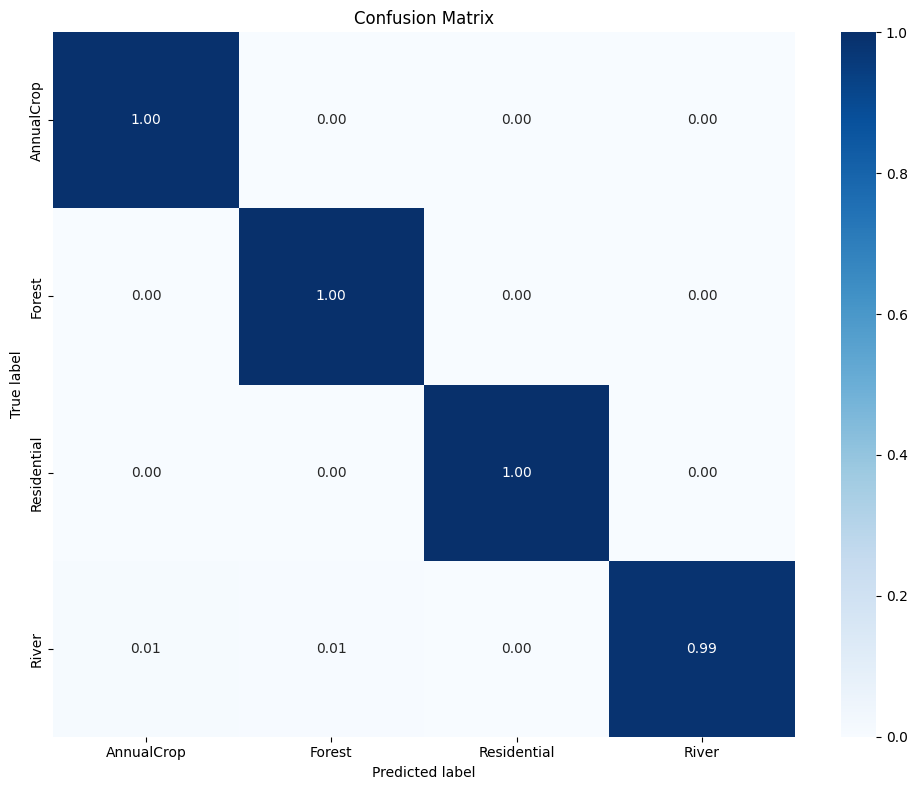

In [31]:
plot_confusion_matrix(metrics_clean['confusion_matrix'], metrics_clean['class_names'], normalize=True)


### 7. Evaluate on Adversarial Test Data

In [32]:
print("\n⚔️ Evaluating on PGD adversarial test set...")
adv_dir = '../data/adv/adv_2'

res_eval = evaluate_adv(
    model_path=adv_checkpoint_path,
    adv_folder=adv_dir,
    model_name=model_name,
    device=device,
    data_dir=data_dir,
    batch_size=batch_size,
    mean_std_sample_size=2000,
    image_pattern="*.tif"
)

print("\n📈 Test Set Performance:")
print(f"Num images: {res_eval['num_images']}")
print(f"Accuracy: {res_eval['accuracy']*100:.2f}%")
print(f"Loss: {res_eval['loss']:.4f}")
print(f"Precision: {res_eval['precision']:.4f}")
print(f"Recall: {res_eval['recall']:.4f}")
print(f"F1-score: {res_eval['f1']:.4f}")

print("\nClassification metrics per category:\n\n", res_eval["classification_report"])


⚔️ Evaluating on PGD adversarial test set...

📈 Test Set Performance:
Num images: 100
Accuracy: 48.00%
Loss: 4.9159
Precision: 0.2602
Recall: 0.4333
F1-score: 0.3132

Classification metrics per category:

               precision    recall  f1-score   support

  AnnualCrop     0.6471    0.7333    0.6875        30
      Forest     0.3939    1.0000    0.5652        26
 Residential     0.0000    0.0000    0.0000        24
       River     0.0000    0.0000    0.0000        20

    accuracy                         0.4800       100
   macro avg     0.2602    0.4333    0.3132       100
weighted avg     0.2965    0.4800    0.3532       100



- Confusion Matrix

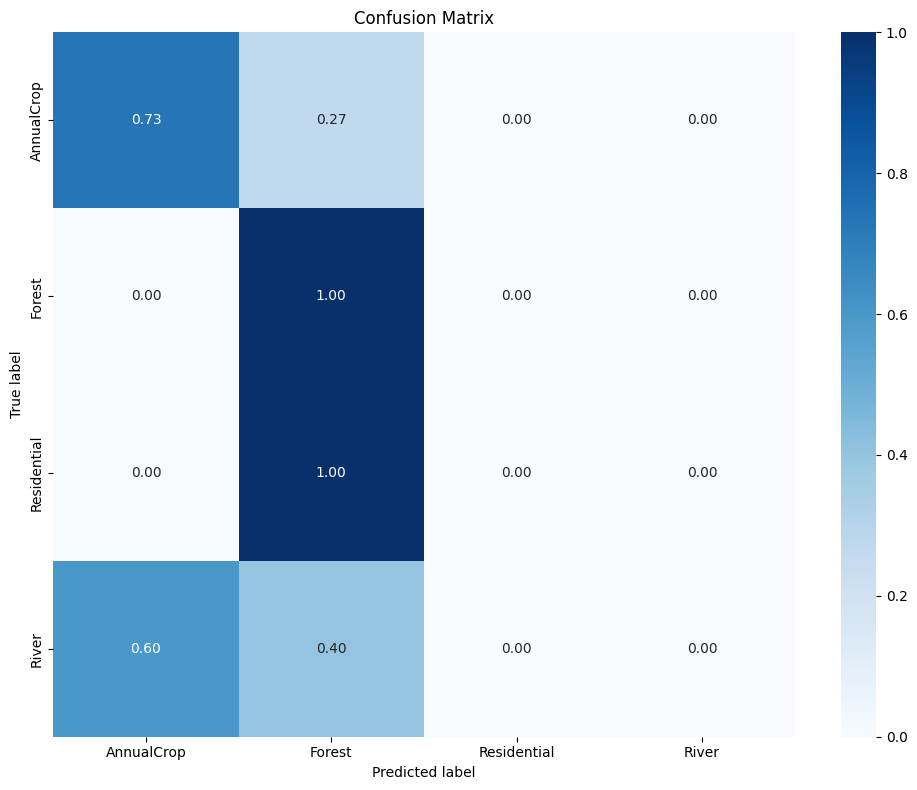

In [33]:
plot_confusion_matrix(res_eval['confusion_matrix'], res_eval['class_names'], normalize=True)
